/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


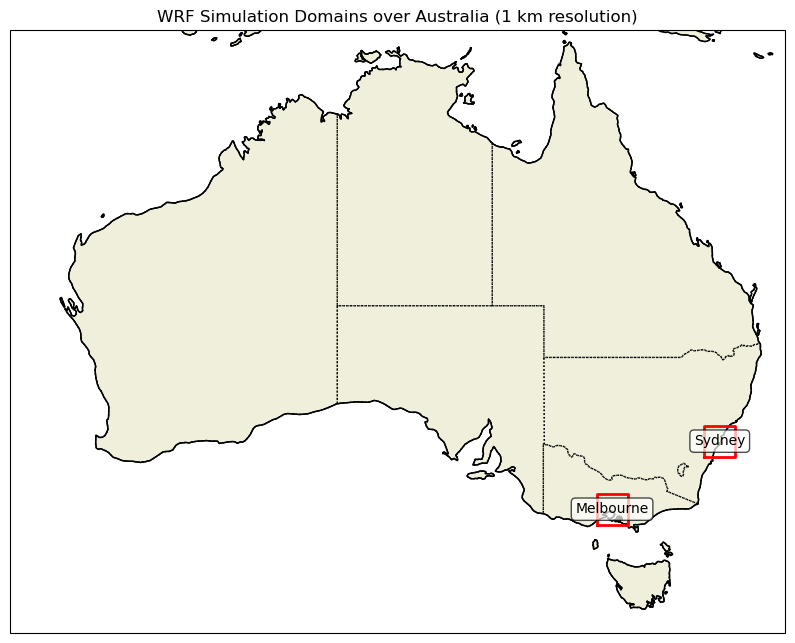

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_wrf_domain(ax, center_lat, center_lon, dx_km, nx, ny, label=None):
    # Approx conversion from km to degrees (valid near mid-latitudes)
    dx_deg = dx_km / 111
    dy_deg = dx_km / 111

    half_width = dx_deg * nx / 2
    half_height = dy_deg * ny / 2

    west = center_lon - half_width
    east = center_lon + half_width
    south = center_lat - half_height
    north = center_lat + half_height

    ax.plot([west, east, east, west, west],
            [south, south, north, north, south],
            color='red', linewidth=2, transform=ccrs.PlateCarree())
    
    if label:
        ax.text(center_lon, center_lat, label, transform=ccrs.PlateCarree(),
                fontsize=10, ha='center', va='center', color='black',
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

# Set up the map
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([110, 155, -45, -10], crs=ccrs.PlateCarree())

# Add geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=0)
ax.set_title('WRF Simulation Domains over Australia (1 km resolution)')

# Plot domains (adjust grid size and centers as needed)
plot_wrf_domain(ax, center_lat=-33.86, center_lon=151.21, dx_km=1, nx=200, ny=200, label='Sydney')
plot_wrf_domain(ax, center_lat=-37.81, center_lon=144.96, dx_km=1, nx=200, ny=200, label='Melbourne')

plt.show()


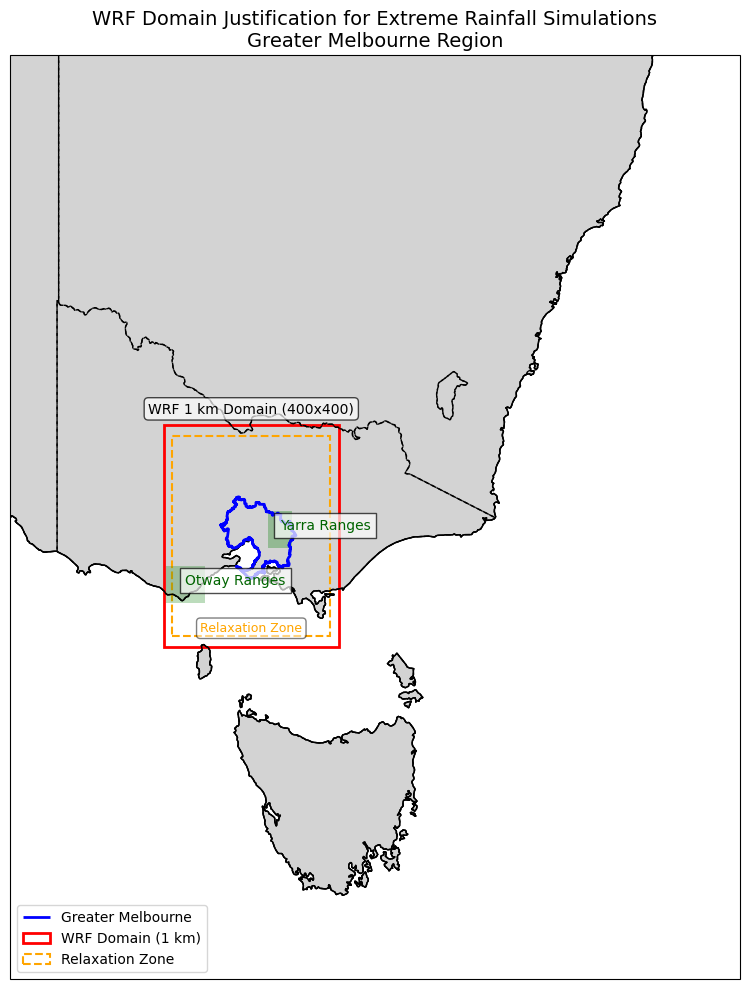

In [14]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle, Polygon

# === Load shapefile of Greater Capital City Statistical Areas ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
melbourne_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Melbourne", case=False)]

# # Ensure CRS matches
# if melbourne_shp.crs != stations_gdf.crs:
#     melbourne_shp = melbourne_shp.to_crs(stations_gdf.crs)

# # Filter stations within Greater Melbourne
# stations_in_melb = stations_gdf[stations_gdf.within(melbourne_shp.unary_union)]

# === Set WRF Domain Parameters ===
center_lat, center_lon = -37.81, 144.96
dx_km = 1
nx = ny = 400
deg_per_km = 1 / 111
half_width = dx_km * nx / 2 * deg_per_km
half_height = dx_km * ny / 2 * deg_per_km
west, east = center_lon - half_width, center_lon + half_width
south, north = center_lat - half_height, center_lat + half_height
relax_deg = 20 * deg_per_km

# === Create Map ===
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140, 155, -45, -30], crs=ccrs.PlateCarree())

# Base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Greater Melbourne boundary
melbourne_shp.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Greater Melbourne')

# # AWS Stations
# ax.scatter(stations_in_melb['Longitude'], stations_in_melb['Latitude'], s=70, color='red',
#            transform=ccrs.PlateCarree(), label='AWS Stations', zorder=5)
# for idx, row in stations_in_melb.iterrows():
#     ax.text(row['Longitude'] + 0.05, row['Latitude'], row['Station'], fontsize=9,
#             transform=ccrs.PlateCarree(), color='black')

# WRF Domain
ax.add_patch(Rectangle((west, south), east - west, north - south,
                       edgecolor='red', facecolor='none', lw=2,
                       transform=ccrs.PlateCarree(), label='WRF Domain (1 km)'))
ax.text(center_lon, north + 0.15, "WRF 1 km Domain (400x400)", fontsize=10,
        ha='center', va='bottom', transform=ccrs.PlateCarree(),
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

# Relaxation Zone
ax.add_patch(Rectangle((west + relax_deg, south + relax_deg),
                       (east - west) - 2 * relax_deg, (north - south) - 2 * relax_deg,
                       edgecolor='orange', facecolor='none', lw=1.5, linestyle='--',
                       transform=ccrs.PlateCarree(), label='Relaxation Zone'))
ax.text(center_lon, south + 0.2, "Relaxation Zone", fontsize=9,
        ha='center', va='bottom', color='orange', transform=ccrs.PlateCarree(),
        bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))

# Yarra Ranges
yarra_poly = Polygon([[145.3, -38.0], [145.8, -38.0], [145.8, -37.4], [145.3, -37.4]],
                     closed=True, facecolor='green', alpha=0.3, transform=ccrs.PlateCarree())
ax.add_patch(yarra_poly)
ax.text(145.55, -37.7, "Yarra Ranges", transform=ccrs.PlateCarree(), fontsize=10,
        color='darkgreen', bbox=dict(facecolor='white', alpha=0.7))

# Otway Ranges
otway_poly = Polygon([[143.2, -38.9], [144.0, -38.9], [144.0, -38.3], [143.2, -38.3]],
                     closed=True, facecolor='forestgreen', alpha=0.3, transform=ccrs.PlateCarree())
ax.add_patch(otway_poly)
ax.text(143.6, -38.6, "Otway Ranges", transform=ccrs.PlateCarree(), fontsize=10,
        color='darkgreen', bbox=dict(facecolor='white', alpha=0.7))

# # Storm Inflow
# ax.annotate('Storm Inflow (NW)', xy=(143, -36), xytext=(141, -34.5),
#             arrowprops=dict(facecolor='blue', width=2, headwidth=8),
#             fontsize=10, color='blue', transform=ccrs.PlateCarree())

# Final plot elements
ax.set_title("WRF Domain Justification for Extreme Rainfall Simulations\nGreater Melbourne Region", fontsize=14)
ax.legend(loc='lower left')

plt.show()


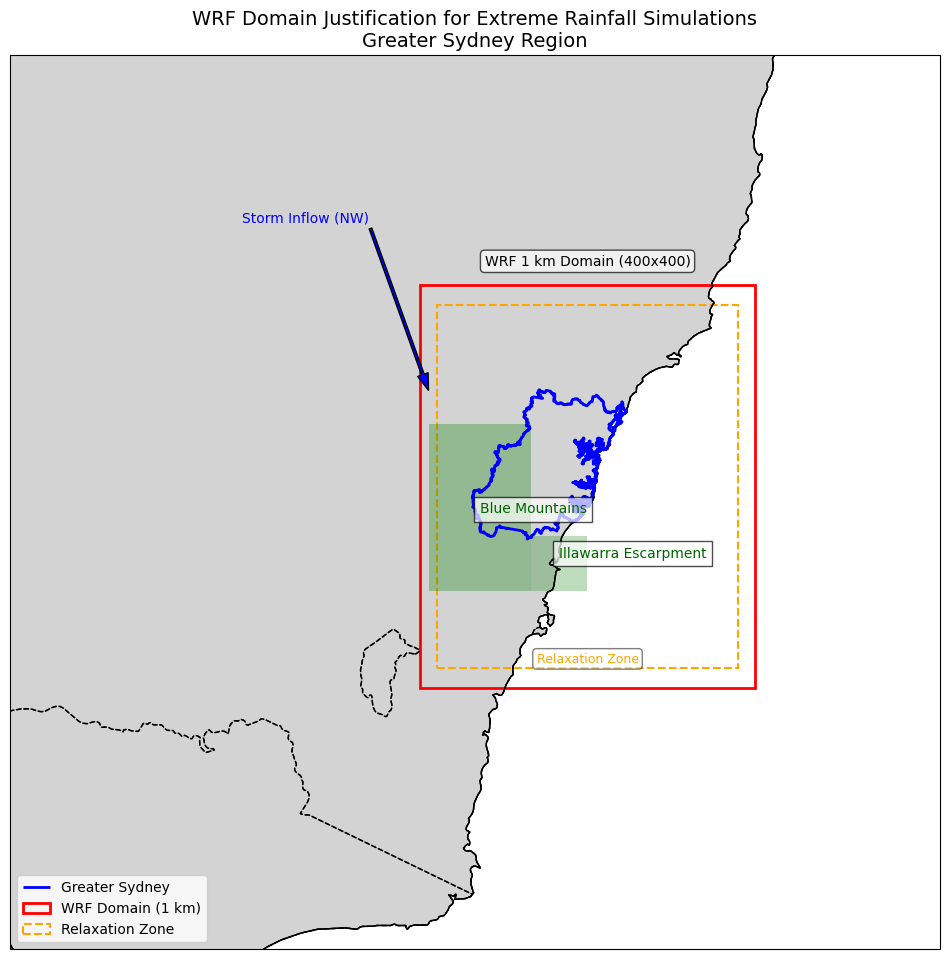

In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle, Polygon

# === Load GCCSA shapefile and select Greater Sydney ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
sydney_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Sydney", case=False)]

# === Set WRF Domain Parameters ===
center_lat, center_lon = -33.86, 151.21
dx_km = 1
nx = ny = 400
deg_per_km = 1 / 111
half_width = dx_km * nx / 2 * deg_per_km
half_height = dx_km * ny / 2 * deg_per_km
west, east = center_lon - half_width, center_lon + half_width
south, north = center_lat - half_height, center_lat + half_height
relax_deg = 20 * deg_per_km

# === Create Map ===
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([145, 155, -38, -30], crs=ccrs.PlateCarree())

# Base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Greater Sydney boundary
sydney_shp.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Greater Sydney')

# WRF Domain
ax.add_patch(Rectangle((west, south), east - west, north - south,
                       edgecolor='red', facecolor='none', lw=2,
                       transform=ccrs.PlateCarree(), label='WRF Domain (1 km)'))
ax.text(center_lon, north + 0.15, "WRF 1 km Domain (400x400)", fontsize=10,
        ha='center', va='bottom', transform=ccrs.PlateCarree(),
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

# Relaxation Zone
ax.add_patch(Rectangle((west + relax_deg, south + relax_deg),
                       (east - west) - 2 * relax_deg, (north - south) - 2 * relax_deg,
                       edgecolor='orange', facecolor='none', lw=1.5, linestyle='--',
                       transform=ccrs.PlateCarree(), label='Relaxation Zone'))
ax.text(center_lon, south + 0.2, "Relaxation Zone", fontsize=9,
        ha='center', va='bottom', color='orange', transform=ccrs.PlateCarree(),
        bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))

# Blue Mountains (approximate polygon to the west of Sydney)
blue_mountains_poly = Polygon([[149.5, -34.8], [150.6, -34.8], [150.6, -33.3], [149.5, -33.3]],
                              closed=True, facecolor='green', alpha=0.3, transform=ccrs.PlateCarree())
ax.add_patch(blue_mountains_poly)
ax.text(150.05, -34.1, "Blue Mountains", transform=ccrs.PlateCarree(), fontsize=10,
        color='darkgreen', bbox=dict(facecolor='white', alpha=0.7))

# Illawarra Escarpment (approximate polygon to the south)
illawarra_poly = Polygon([[150.6, -34.8], [151.2, -34.8], [151.2, -34.3], [150.6, -34.3]],
                         closed=True, facecolor='forestgreen', alpha=0.3, transform=ccrs.PlateCarree())
ax.add_patch(illawarra_poly)
ax.text(150.9, -34.5, "Illawarra Escarpment", transform=ccrs.PlateCarree(), fontsize=10,
        color='darkgreen', bbox=dict(facecolor='white', alpha=0.7))

# Storm Inflow (from NW inland)
ax.annotate('Storm Inflow (NW)', xy=(149.5, -33), xytext=(147.5, -31.5),
            arrowprops=dict(facecolor='blue', width=2, headwidth=8),
            fontsize=10, color='blue', transform=ccrs.PlateCarree())

# Final plot elements
ax.set_title("WRF Domain Justification for Extreme Rainfall Simulations\nGreater Sydney Region", fontsize=14)
ax.legend(loc='lower left')

plt.show()


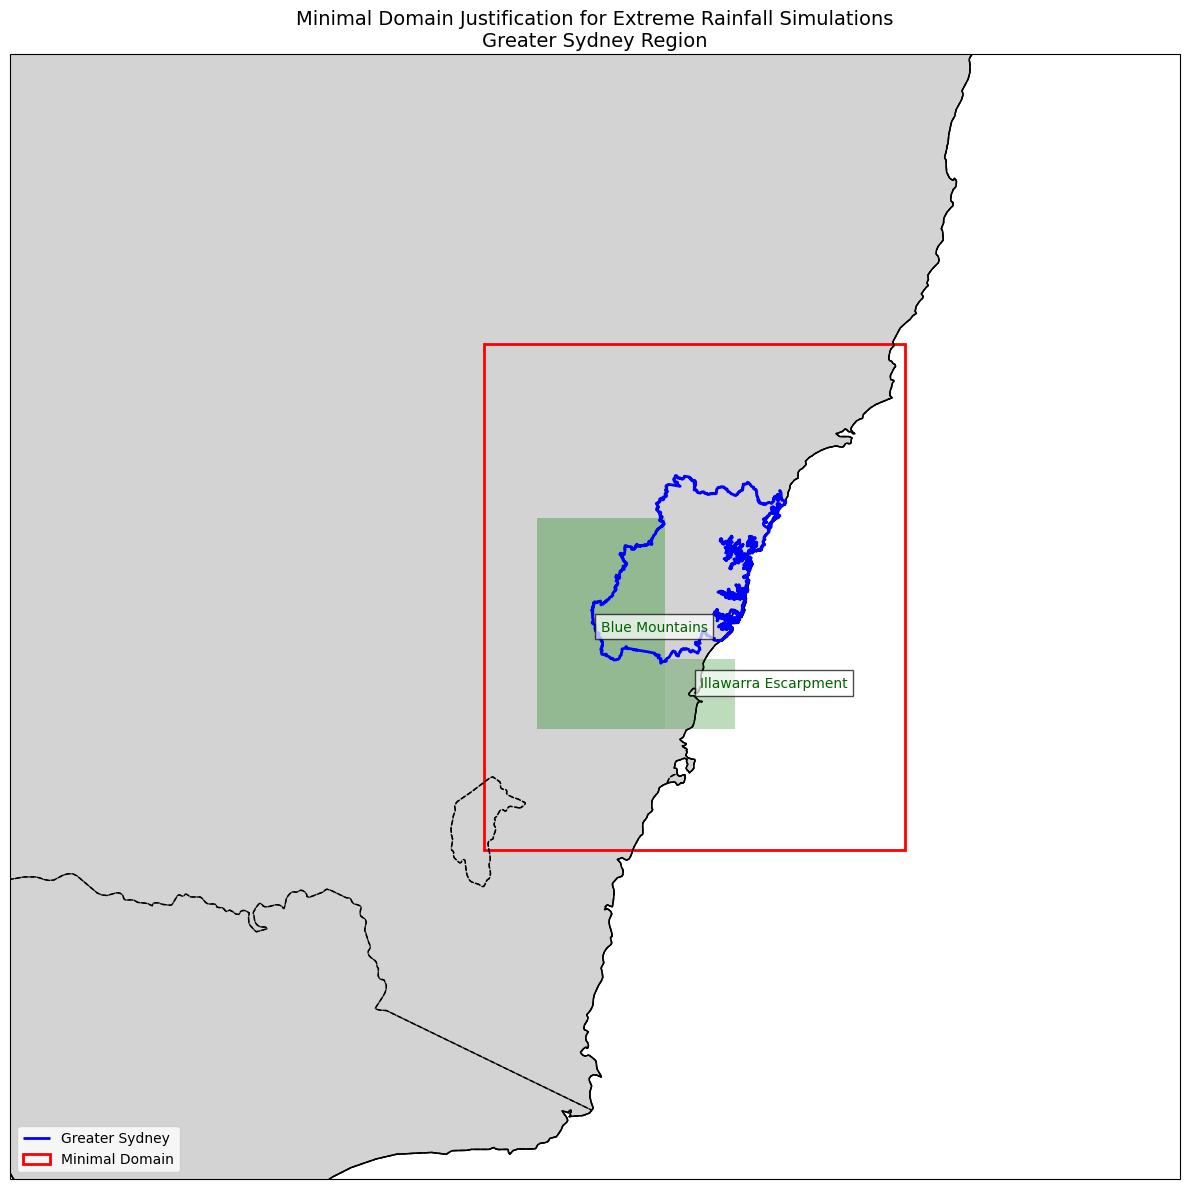

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle, Polygon
import os

# === Load Greater Sydney shapefile ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)
city_name = "Sydney"

gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
sydney_shp = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]

# === Set WRF Domain Parameters (adjusted westward for ~100 km buffer) ===
center_lat, center_lon = -33.86, 150.85  # adjusted center
dx_km = 1
nx = ny = 400
deg_per_km = 1 / 111
half_width = dx_km * nx / 2 * deg_per_km
half_height = dx_km * ny / 2 * deg_per_km
west, east = center_lon - half_width, center_lon + half_width
south, north = center_lat - half_height, center_lat + half_height

# === Create Map ===
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([145, 155, -38, -30])

# Base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Plot Greater Sydney boundary
sydney_shp.boundary.plot(ax=ax, edgecolor='blue', linewidth=2,
                         transform=ccrs.PlateCarree(), label='Greater Sydney')

# Plot WRF Domain (1 km)
ax.add_patch(Rectangle((west, south), east - west, north - south,
                       edgecolor='red', facecolor='none', lw=2,
                       transform=ccrs.PlateCarree(), label='Minimal Domain'))

# Blue Mountains
blue_mountains_poly = Polygon([[149.5, -34.8], [150.6, -34.8], [150.6, -33.3], [149.5, -33.3]],
                              closed=True, facecolor='green', alpha=0.3, transform=ccrs.PlateCarree())
ax.add_patch(blue_mountains_poly)
ax.text(150.05, -34.1, "Blue Mountains", transform=ccrs.PlateCarree(),
        fontsize=10, color='darkgreen', bbox=dict(facecolor='white', alpha=0.7))

# Illawarra Escarpment
illawarra_poly = Polygon([[150.6, -34.8], [151.2, -34.8], [151.2, -34.3], [150.6, -34.3]],
                         closed=True, facecolor='forestgreen', alpha=0.3, transform=ccrs.PlateCarree())
ax.add_patch(illawarra_poly)
ax.text(150.9, -34.5, "Illawarra Escarpment", transform=ccrs.PlateCarree(),
        fontsize=10, color='darkgreen', bbox=dict(facecolor='white', alpha=0.7))

# Final plot elements
ax.set_title("Minimal Domain Justification for Extreme Rainfall Simulations\nGreater Sydney Region", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f"{out_figure_path}/minimum_domain_{city_name}.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

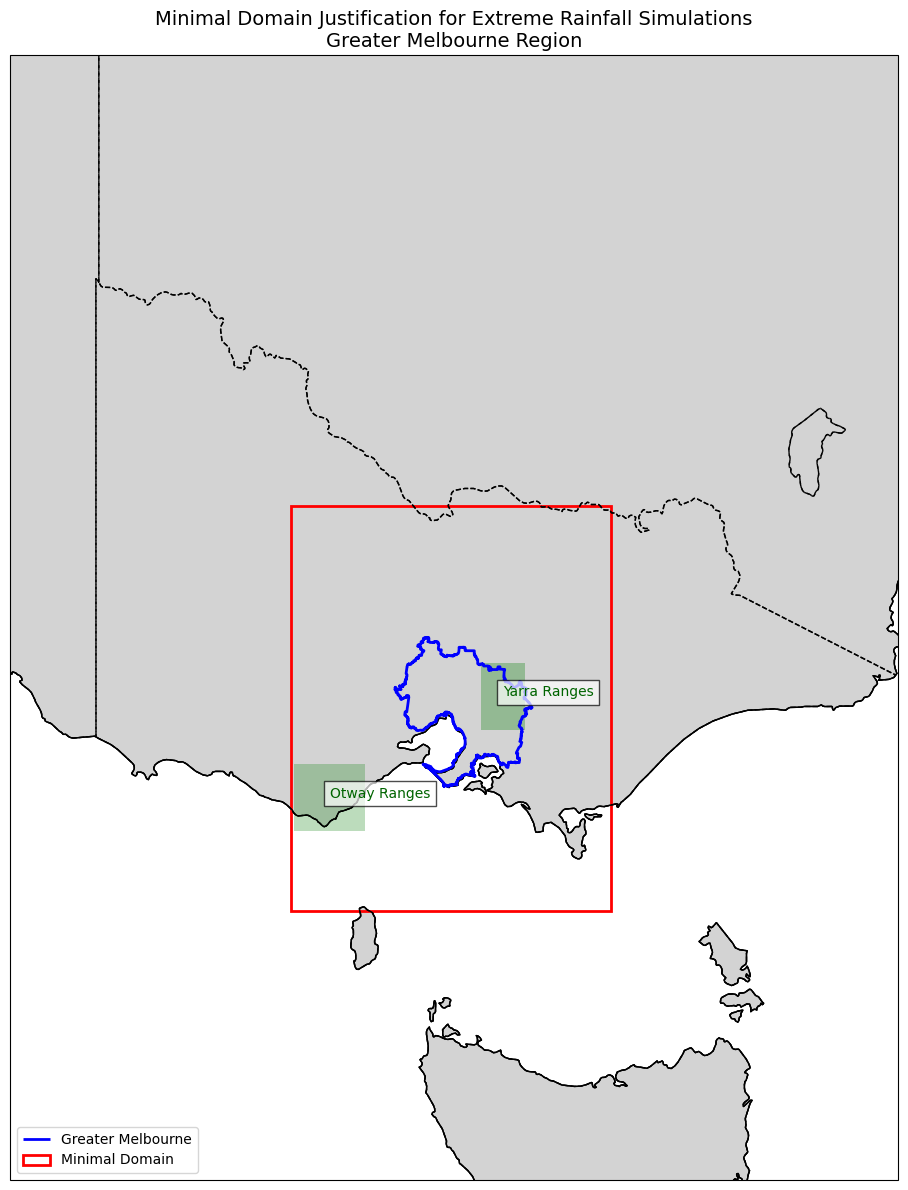

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle, Polygon
import os

# === Load Greater Melbourne shapefile ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)
city_name = "Melbourne"

gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
melbourne_shp = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]

# === WRF Domain Parameters ===
center_lat, center_lon = -37.81, 144.96
dx_km = 1
nx = ny = 400
deg_per_km = 1 / 111
half_width = dx_km * nx / 2 * deg_per_km
half_height = dx_km * ny / 2 * deg_per_km
west, east = center_lon - half_width, center_lon + half_width
south, north = center_lat - half_height, center_lat + half_height

# === Create Map ===
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140, 150, -42, -32])

# Base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Greater Melbourne boundary
melbourne_shp.boundary.plot(ax=ax, edgecolor='blue', linewidth=2,
                            transform=ccrs.PlateCarree(), label='Greater Melbourne')

# WRF Domain box
ax.add_patch(Rectangle((west, south), east - west, north - south,
                       edgecolor='red', facecolor='none', lw=2,
                       transform=ccrs.PlateCarree(), label='Minimal Domain'))

# Terrain labels: Yarra Ranges and Otways
yarra_poly = Polygon([[145.3, -38.0], [145.8, -38.0], [145.8, -37.4], [145.3, -37.4]],
                     closed=True, facecolor='green', alpha=0.3, transform=ccrs.PlateCarree())
ax.add_patch(yarra_poly)
ax.text(145.55, -37.7, "Yarra Ranges", transform=ccrs.PlateCarree(), fontsize=10,
        color='darkgreen', bbox=dict(facecolor='white', alpha=0.7))

otway_poly = Polygon([[143.2, -38.9], [144.0, -38.9], [144.0, -38.3], [143.2, -38.3]],
                     closed=True, facecolor='forestgreen', alpha=0.3, transform=ccrs.PlateCarree())
ax.add_patch(otway_poly)
ax.text(143.6, -38.6, "Otway Ranges", transform=ccrs.PlateCarree(), fontsize=10,
        color='darkgreen', bbox=dict(facecolor='white', alpha=0.7))

# Finalize plot
ax.set_title("Minimal Domain Justification for Extreme Rainfall Simulations\nGreater Melbourne Region", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()

plt.savefig(f"{out_figure_path}/minimum_domain_{city_name}.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


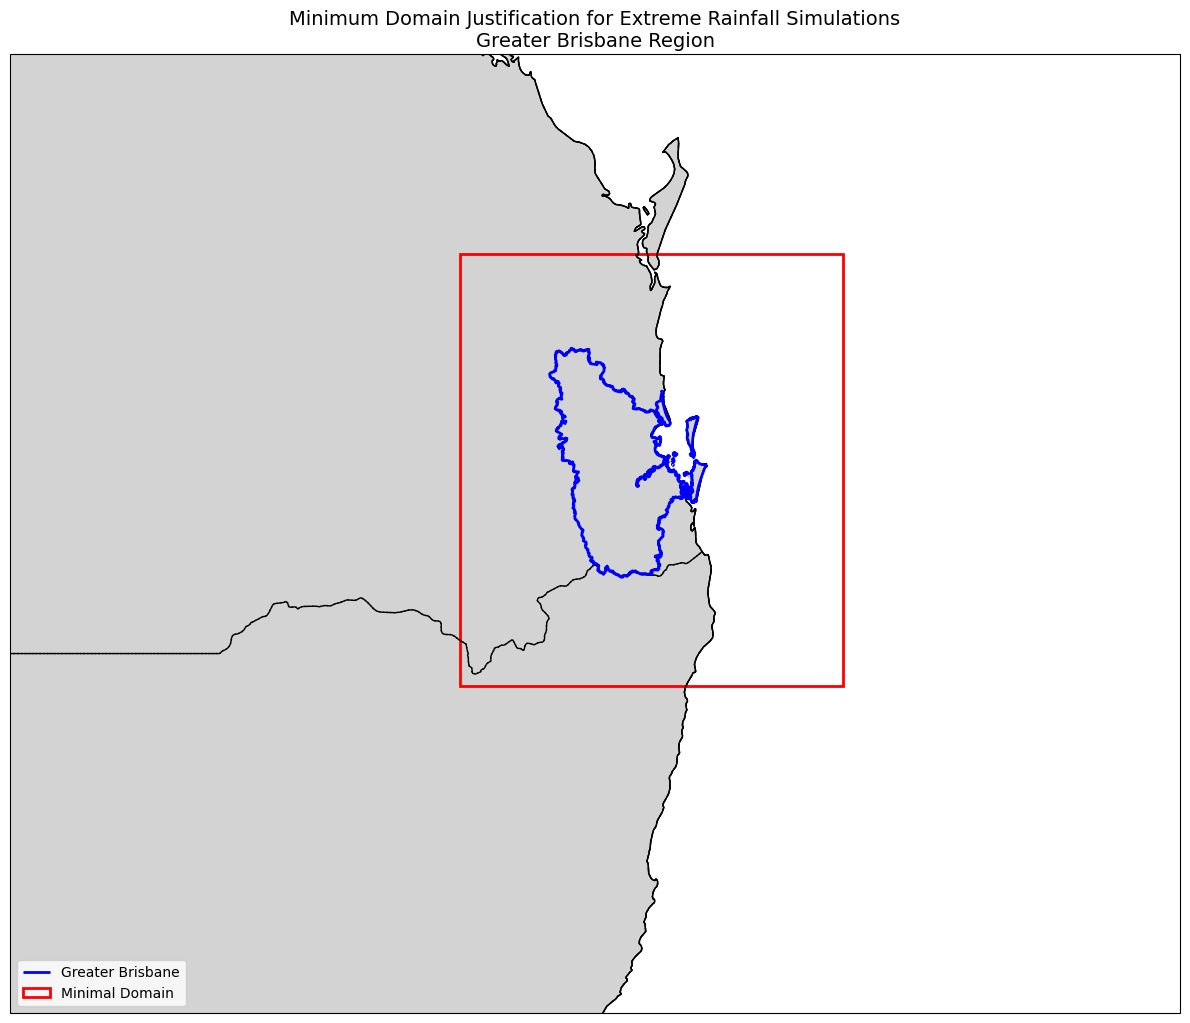

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import os

# === Load GCCSA shapefile and select Greater Brisbane ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)
city_name = "Brisbane"

gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
brisbane_shp = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]

# === Domain Parameters ===
center_lat, center_lon = -27.47, 153.03
dx_km = 1
nx = ny = 400
deg_per_km = 1 / 111
half_width = dx_km * nx / 2 * deg_per_km
half_height = dx_km * ny / 2 * deg_per_km
west, east = center_lon - half_width, center_lon + half_width
south, north = center_lat - half_height, center_lat + half_height

# === Create Map ===
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([147, 158, -32, -24], crs=ccrs.PlateCarree())

# Base map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Greater Brisbane boundary
brisbane_shp.boundary.plot(ax=ax, edgecolor='blue', linewidth=2,
                           transform=ccrs.PlateCarree(), label='Greater Brisbane')

# Plot domain rectangle
ax.add_patch(Rectangle((west, south), east - west, north - south,
                       edgecolor='red', facecolor='none', lw=2,
                       transform=ccrs.PlateCarree(), label='Minimal Domain'))

# Title and legend
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nGreater Brisbane Region", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()

# Save to desired path
plt.savefig(f"{out_figure_path}/minimum_domain_{city_name}.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import os

# === Setup ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)
city_name = "Perth"

# === Load GCCSA shapefile and select Greater Perth ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
perth_shp = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]

# === Domain Parameters ===
center_lat, center_lon = -31.95, 115.86  # Approximate center of Perth CBD
dx_km = 1
nx = ny = 400
deg_per_km = 1 / 111
half_width = dx_km * nx / 2 * deg_per_km
half_height = dx_km * ny / 2 * deg_per_km
west, east = center_lon - half_width, center_lon + half_width
south, north = center_lat - half_height, center_lat + half_height

# === Create Map ===
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([110, 122, -36, -25], crs=ccrs.PlateCarree())

# Base map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Greater Perth boundary
perth_shp.boundary.plot(ax=ax, edgecolor='blue', linewidth=2,
                        transform=ccrs.PlateCarree(), label='Greater Perth')

# Plot domain rectangle
ax.add_patch(Rectangle((west, south), east - west, north - south,
                       edgecolor='red', facecolor='none', lw=2,
                       transform=ccrs.PlateCarree(), label='Minimal Domain'))

# Title and legend
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nGreater Perth Region", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()

# Save to desired path
plt.savefig(f"{out_figure_path}/minimum_domain_{city_name.lower()}.png", dpi=300, bbox_inches='tight')
plt.close()

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import os

# === Setup ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)
city_name = "Adelaide"

# === Load GCCSA shapefile and select Greater Adelaide ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
adelaide_shp = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]

# === Domain Parameters ===
center_lat, center_lon = -34.93, 138.60  # Approximate center of Adelaide CBD
dx_km = 1
nx = ny = 400
deg_per_km = 1 / 111
half_width = dx_km * nx / 2 * deg_per_km
half_height = dx_km * ny / 2 * deg_per_km
west, east = center_lon - half_width, center_lon + half_width
south, north = center_lat - half_height, center_lat + half_height

# === Create Map ===
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([132, 145, -40, -28], crs=ccrs.PlateCarree())

# Base map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Greater Adelaide boundary
adelaide_shp.boundary.plot(ax=ax, edgecolor='blue', linewidth=2,
                           transform=ccrs.PlateCarree(), label='Greater Adelaide')

# Plot domain rectangle
ax.add_patch(Rectangle((west, south), east - west, north - south,
                       edgecolor='red', facecolor='none', lw=2,
                       transform=ccrs.PlateCarree(), label='Minimal Domain'))

# Title and legend
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nGreater Adelaide Region", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()

# Save to desired path
plt.savefig(f"{out_figure_path}/minimum_domain_{city_name}.png", dpi=300, bbox_inches='tight')
plt.close()

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import os

# === Setup ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)
city_name = "Hobart"

# === Load GCCSA shapefile and select Greater Hobart ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
hobart_shp = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]

# === Domain Parameters ===
center_lat, center_lon = -42.88, 147.33  # Approximate center of Hobart CBD
dx_km = 1
nx = ny = 400
deg_per_km = 1 / 111
half_width = dx_km * nx / 2 * deg_per_km
half_height = dx_km * ny / 2 * deg_per_km
west, east = center_lon - half_width, center_lon + half_width
south, north = center_lat - half_height, center_lat + half_height

# === Create Map ===
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140, 150, -47, -39], crs=ccrs.PlateCarree())

# Base map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Greater Hobart boundary
hobart_shp.boundary.plot(ax=ax, edgecolor='blue', linewidth=2,
                         transform=ccrs.PlateCarree(), label='Greater Hobart')

# Plot domain rectangle
ax.add_patch(Rectangle((west, south), east - west, north - south,
                       edgecolor='red', facecolor='none', lw=2,
                       transform=ccrs.PlateCarree(), label='Minimal Domain'))

# Title and legend
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nGreater Hobart Region", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()

# Save to desired path
plt.savefig(f"{out_figure_path}/minimum_domain_{city_name}.png", dpi=300, bbox_inches='tight')
plt.close()

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import os

# === Setup ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)
city_name = "Darwin"

# === Load GCCSA shapefile and select Greater Darwin ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
darwin_shp = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]

# === Domain Parameters ===
center_lat, center_lon = -12.46, 130.84  # Approximate Darwin CBD
dx_km = 1
nx = ny = 400
deg_per_km = 1 / 111
half_width = dx_km * nx / 2 * deg_per_km
half_height = dx_km * ny / 2 * deg_per_km
west, east = center_lon - half_width, center_lon + half_width
south, north = center_lat - half_height, center_lat + half_height

# === Create Map ===
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([124, 138, -18, -8], crs=ccrs.PlateCarree())

# Base map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Greater Darwin boundary
darwin_shp.boundary.plot(ax=ax, edgecolor='blue', linewidth=2,
                         transform=ccrs.PlateCarree(), label='Greater Darwin')

# Plot domain rectangle
ax.add_patch(Rectangle((west, south), east - west, north - south,
                       edgecolor='red', facecolor='none', lw=2,
                       transform=ccrs.PlateCarree(), label='Minimal Domain'))

# Title and legend
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nGreater Darwin Region", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()

# Save to desired path
plt.savefig(f"{out_figure_path}/minimum_domain_{city_name}.png", dpi=300, bbox_inches='tight')
plt.close()

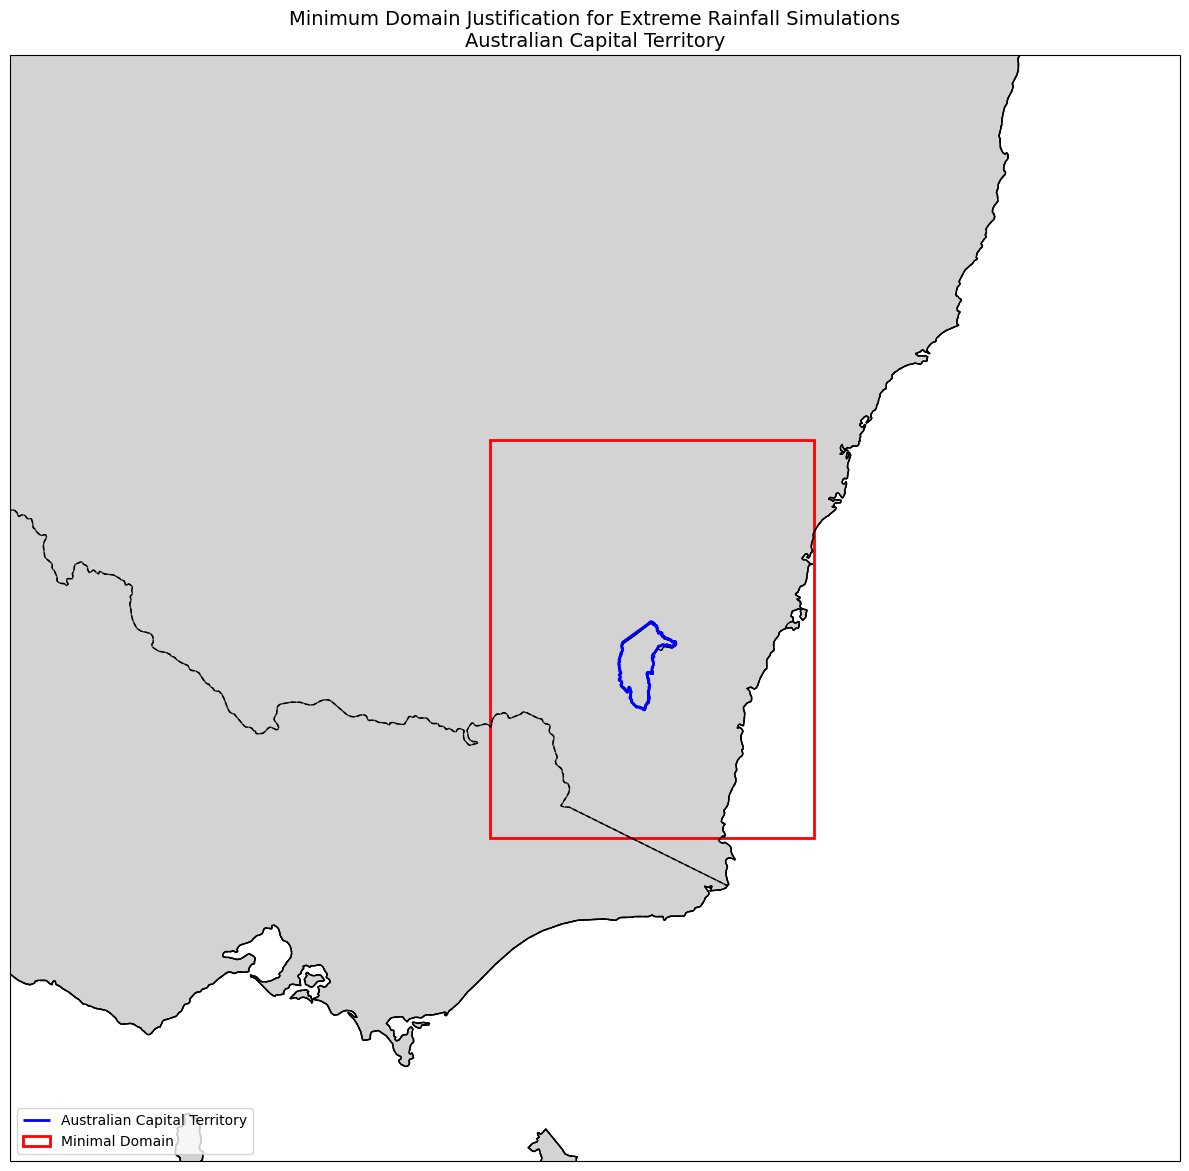

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import os

# === Setup ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)
city_name = "capital"

# === Load GCCSA shapefile and select Greater Canberra ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
canberra_shp = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]

# === Domain Parameters ===
center_lat, center_lon = -35.28, 149.13  # Approximate center of Canberra CBD
dx_km = 1
nx = ny = 400
deg_per_km = 1 / 111
half_width = dx_km * nx / 2 * deg_per_km
half_height = dx_km * ny / 2 * deg_per_km
west, east = center_lon - half_width, center_lon + half_width
south, north = center_lat - half_height, center_lat + half_height

# === Create Map ===
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([142, 155, -40, -30], crs=ccrs.PlateCarree())

# Base map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Greater Canberra boundary
canberra_shp.boundary.plot(ax=ax, edgecolor='blue', linewidth=2,
                         transform=ccrs.PlateCarree(), label='Australian Capital Territory')

# Plot domain rectangle
ax.add_patch(Rectangle((west, south), east - west, north - south,
                       edgecolor='red', facecolor='none', lw=2,
                       transform=ccrs.PlateCarree(), label='Minimal Domain'))

# Title and legend
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nAustralian Capital Territory", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()

# Save to desired path
plt.savefig(f"{out_figure_path}/minimum_domain_{city_name}.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [11]:
darwin_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Capital", case=False)]
print(darwin_shp)

   GCC_CODE21                    GCC_NAME21 CHG_FLAG21  CHG_LBL21 STE_CODE21  \
28      8ACTE  Australian Capital Territory          0  No change          8   

                      STE_NAME21 AUS_CODE21 AUS_NAME21  AREASQKM21  \
28  Australian Capital Territory        AUS  Australia    2358.133   

                                           LOCI_URI21  \
28  http://linked.data.gov.au/dataset/asgsed3/GCCS...   

                                             geometry  
28  POLYGON ((149.06239 -35.15910, 149.09134 -35.1...  


In [10]:
c_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Canberra", case=False)]
print(gccsa["GCC_NAME21"])

0                             Greater Sydney
1                                Rest of NSW
2                     No usual address (NSW)
3      Migratory - Offshore - Shipping (NSW)
4                          Greater Melbourne
5                               Rest of Vic.
6                    No usual address (Vic.)
7     Migratory - Offshore - Shipping (Vic.)
8                           Greater Brisbane
9                                Rest of Qld
10                    No usual address (Qld)
11     Migratory - Offshore - Shipping (Qld)
12                          Greater Adelaide
13                                Rest of SA
14                     No usual address (SA)
15      Migratory - Offshore - Shipping (SA)
16                             Greater Perth
17                                Rest of WA
18                     No usual address (WA)
19      Migratory - Offshore - Shipping (WA)
20                            Greater Hobart
21                              Rest of Tas.
22        

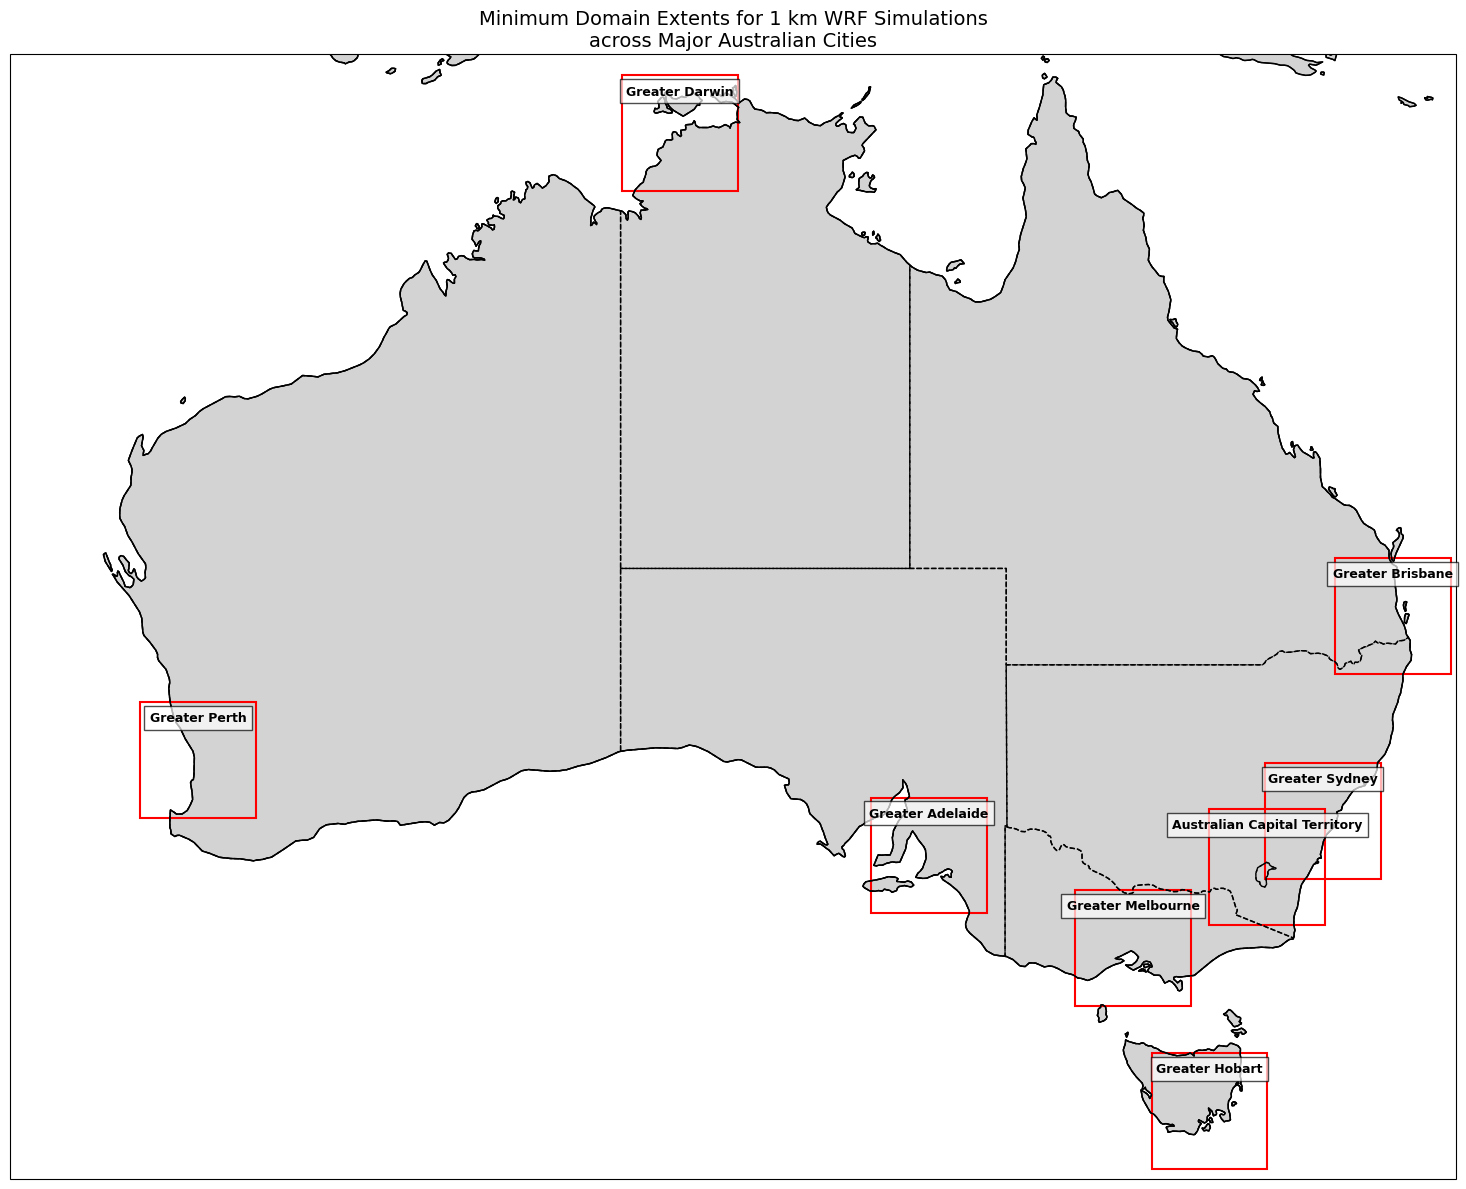

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import os

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === City data: lat/lon ===
cities = {
    "Greater Sydney":    {"lat": -33.86, "lon": 150.85},
    "Greater Melbourne": {"lat": -37.81, "lon": 144.96},
    "Greater Brisbane":  {"lat": -27.47, "lon": 153.03},
    "Greater Perth":     {"lat": -31.95, "lon": 115.86},
    "Greater Adelaide":  {"lat": -34.93, "lon": 138.60},
    "Greater Hobart":    {"lat": -42.88, "lon": 147.33},
    "Greater Darwin":    {"lat": -12.46, "lon": 130.84},
    "Australian Capital Territory":  {"lat": -35.28, "lon": 149.13}
}

# === WRF 1 km domain size ===
dx_km = 1
nx = ny = 400
deg_per_km = 1 / 111
half_width = dx_km * nx / 2 * deg_per_km
half_height = dx_km * ny / 2 * deg_per_km

# === Load shapefile of GCCSA ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)

# === Create national map ===
fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([110, 155, -45, -10], crs=ccrs.PlateCarree())

# Basemap features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Plot city boundaries and domains
for city, info in cities.items():
    lat, lon = info['lat'], info['lon']
    west, east = lon - half_width, lon + half_width
    south, north = lat - half_height, lat + half_height
    ax.add_patch(Rectangle((west, south), east - west, north - south,
                           edgecolor='red', facecolor='none', lw=1.5,
                           transform=ccrs.PlateCarree()))
    ax.text(lon, lat + 1.2, city, ha='center', fontsize=9, weight='bold',
            transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=0.7))

# Finalize
ax.set_title("Minimum Domain Extents for 1 km WRF Simulations\nacross Major Australian Cities", fontsize=14)
plt.tight_layout()
plt.savefig(f"{out_figure_path}/summary_minimum_domains_australia.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [ ]:
### hybrid strategy

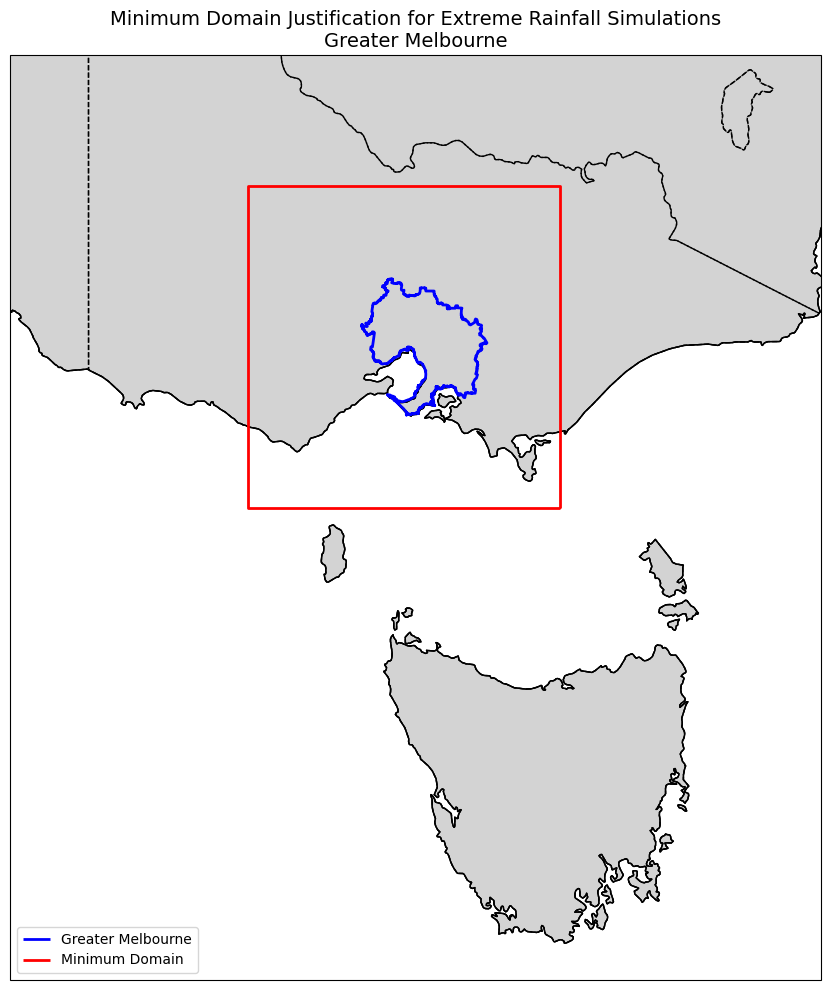

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import os

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load shapefile and filter Greater Melbourne ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
melbourne = gccsa[gccsa["GCC_NAME21"].str.contains("Melbourne", case=False)].to_crs(epsg=4326)

# === Approximate ~100 km buffer in degrees (~0.9 deg) + extra westward extension (~0.5 deg) ===
buffer_deg = 0.9
minx, miny, maxx, maxy = melbourne.total_bounds
west, east = minx - buffer_deg - 0.5, maxx + buffer_deg
south, north = miny - buffer_deg, maxy + buffer_deg

# === Create bounding box ===
domain_box = box(west, south, east, north)
domain_gdf = gpd.GeoDataFrame(geometry=[domain_box], crs='EPSG:4326')

# === Plot map ===
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140, 150, -44, -35])

# Base features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Plot regions
melbourne.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Greater Melbourne')
domain_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), label='Minimum Domain')

# Title and save
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nGreater Melbourne", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f"{out_figure_path}/hybrid_minimum_domain_melbourne_simplified.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import os

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load shapefile and filter Greater Sydney ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
sydney = gccsa[gccsa["GCC_NAME21"].str.contains("Sydney", case=False)].to_crs(epsg=4326)

# === Approximate ~100 km buffer in degrees (~0.9 deg) + extra westward extension (~0.5 deg) ===
buffer_deg = 0.9
minx, miny, maxx, maxy = sydney.total_bounds
west, east = minx - buffer_deg - 0.5, maxx + buffer_deg
south, north = miny - buffer_deg, maxy + buffer_deg

# === Create bounding box ===
domain_box = box(west, south, east, north)
domain_gdf = gpd.GeoDataFrame(geometry=[domain_box], crs='EPSG:4326')

# === Plot map ===
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([145, 155, -38, -30])

# Base features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Plot regions
sydney.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Greater Sydney')
domain_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), label='Minimum Domain')

# Title and save
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nGreater Sydney", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f"{out_figure_path}/hybrid_minimum_domain_sydney_simplified.png", dpi=300, bbox_inches='tight')
plt.close()

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import os

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load shapefile and filter Greater Brisbane ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
brisbane = gccsa[gccsa["GCC_NAME21"].str.contains("Brisbane", case=False)].to_crs(epsg=4326)

# === Apply ~100 km buffer in degrees (~0.9 deg) + slight westward extension (~0.5 deg) ===
buffer_deg = 0.9
minx, miny, maxx, maxy = brisbane.total_bounds
west, east = minx - buffer_deg - 0.5, maxx + buffer_deg
south, north = miny - buffer_deg, maxy + buffer_deg

# === Create bounding box ===
domain_box = box(west, south, east, north)
domain_gdf = gpd.GeoDataFrame(geometry=[domain_box], crs='EPSG:4326')

# === Plot map ===
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([147, 158, -32, -24])

# Base features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Plot regions
brisbane.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Greater Brisbane')
domain_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), label='Minimum Domain')

# Title and save
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nGreater Brisbane", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f"{out_figure_path}/minimum_domain_brisbane_simplified.png", dpi=300, bbox_inches='tight')
plt.close()

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import os

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load shapefile and filter Greater Perth ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
perth = gccsa[gccsa["GCC_NAME21"].str.contains("Perth", case=False)].to_crs(epsg=4326)

# === Apply ~100 km buffer in degrees (~0.9 deg) + slight westward extension (~0.5 deg) ===
buffer_deg = 0.9
minx, miny, maxx, maxy = perth.total_bounds
west, east = minx - buffer_deg - 0.5, maxx + buffer_deg
south, north = miny - buffer_deg, maxy + buffer_deg

# === Create bounding box ===
domain_box = box(west, south, east, north)
domain_gdf = gpd.GeoDataFrame(geometry=[domain_box], crs='EPSG:4326')

# === Plot map ===
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([110, 122, -36, -25])

# Base features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Plot regions
perth.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Greater Perth')
domain_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), label='Minimum Domain')

# Title and save
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nGreater Perth", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f"{out_figure_path}/minimum_domain_perth_simplified.png", dpi=300, bbox_inches='tight')
plt.close()

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import os

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load shapefile and filter Greater Adelaide ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
adelaide = gccsa[gccsa["GCC_NAME21"].str.contains("Adelaide", case=False)].to_crs(epsg=4326)

# === Apply ~100 km buffer in degrees (~0.9 deg) + slight westward extension (~0.5 deg) ===
buffer_deg = 0.9
minx, miny, maxx, maxy = adelaide.total_bounds
west, east = minx - buffer_deg - 0.5, maxx + buffer_deg
south, north = miny - buffer_deg, maxy + buffer_deg

# === Create bounding box ===
domain_box = box(west, south, east, north)
domain_gdf = gpd.GeoDataFrame(geometry=[domain_box], crs='EPSG:4326')

# === Plot map ===
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([132, 145, -40, -28])

# Base features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Plot regions
adelaide.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Greater Adelaide')
domain_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), label='Minimum Domain')

# Title and save
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nGreater Adelaide", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f"{out_figure_path}/minimum_domain_adelaide_simplified.png", dpi=300, bbox_inches='tight')
plt.close()

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import os

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load shapefile and filter Greater Hobart ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
hobart = gccsa[gccsa["GCC_NAME21"].str.contains("Hobart", case=False)].to_crs(epsg=4326)

# === Apply ~100 km buffer in degrees (~0.9 deg) + slight westward extension (~0.5 deg) ===
buffer_deg = 0.9
minx, miny, maxx, maxy = hobart.total_bounds
west, east = minx - buffer_deg - 0.5, maxx + buffer_deg
south, north = miny - buffer_deg, maxy + buffer_deg

# === Create bounding box ===
domain_box = box(west, south, east, north)
domain_gdf = gpd.GeoDataFrame(geometry=[domain_box], crs='EPSG:4326')

# === Plot map ===
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([140, 150, -47, -39])

# Base features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Plot regions
hobart.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Greater Hobart')
domain_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), label='Minimum Domain')

# Title and save
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nGreater Hobart", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f"{out_figure_path}/minimum_domain_hobart_simplified.png", dpi=300, bbox_inches='tight')
plt.close()

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import os

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load shapefile and filter Greater Darwin ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
darwin = gccsa[gccsa["GCC_NAME21"].str.contains("Darwin", case=False)].to_crs(epsg=4326)

# === Apply ~100 km buffer in degrees (~0.9 deg) + slight westward extension (~0.5 deg) ===
buffer_deg = 0.9
minx, miny, maxx, maxy = darwin.total_bounds
west, east = minx - buffer_deg - 0.5, maxx + buffer_deg
south, north = miny - buffer_deg, maxy + buffer_deg

# === Create bounding box ===
domain_box = box(west, south, east, north)
domain_gdf = gpd.GeoDataFrame(geometry=[domain_box], crs='EPSG:4326')

# === Plot map ===
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([124, 138, -18, -8])

# Base features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Plot regions
darwin.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Greater Darwin')
domain_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), label='Minimum Domain')

# Title and save
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nGreater Darwin", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f"{out_figure_path}/minimum_domain_darwin_simplified.png", dpi=300, bbox_inches='tight')
plt.close()

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import os

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load shapefile and filter Greater Canberra ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp)
canberra = gccsa[gccsa["GCC_NAME21"].str.contains("Capital", case=False)].to_crs(epsg=4326)

# === Apply ~100 km buffer in degrees (~0.9 deg) + slight westward extension (~0.5 deg) ===
buffer_deg = 0.9
minx, miny, maxx, maxy = canberra.total_bounds
west, east = minx - buffer_deg - 0.5, maxx + buffer_deg
south, north = miny - buffer_deg, maxy + buffer_deg

# === Create bounding box ===
domain_box = box(west, south, east, north)
domain_gdf = gpd.GeoDataFrame(geometry=[domain_box], crs='EPSG:4326')

# === Plot map ===
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([142, 155, -40, -30])

# Base features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# Plot regions
canberra.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label='Australian Capital Territory')
domain_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), label='Minimum Domain')

# Title and save
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nAustralian Capital Territory", fontsize=14)
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f"{out_figure_path}/minimum_domain_canberra_simplified.png", dpi=300, bbox_inches='tight')
plt.close()

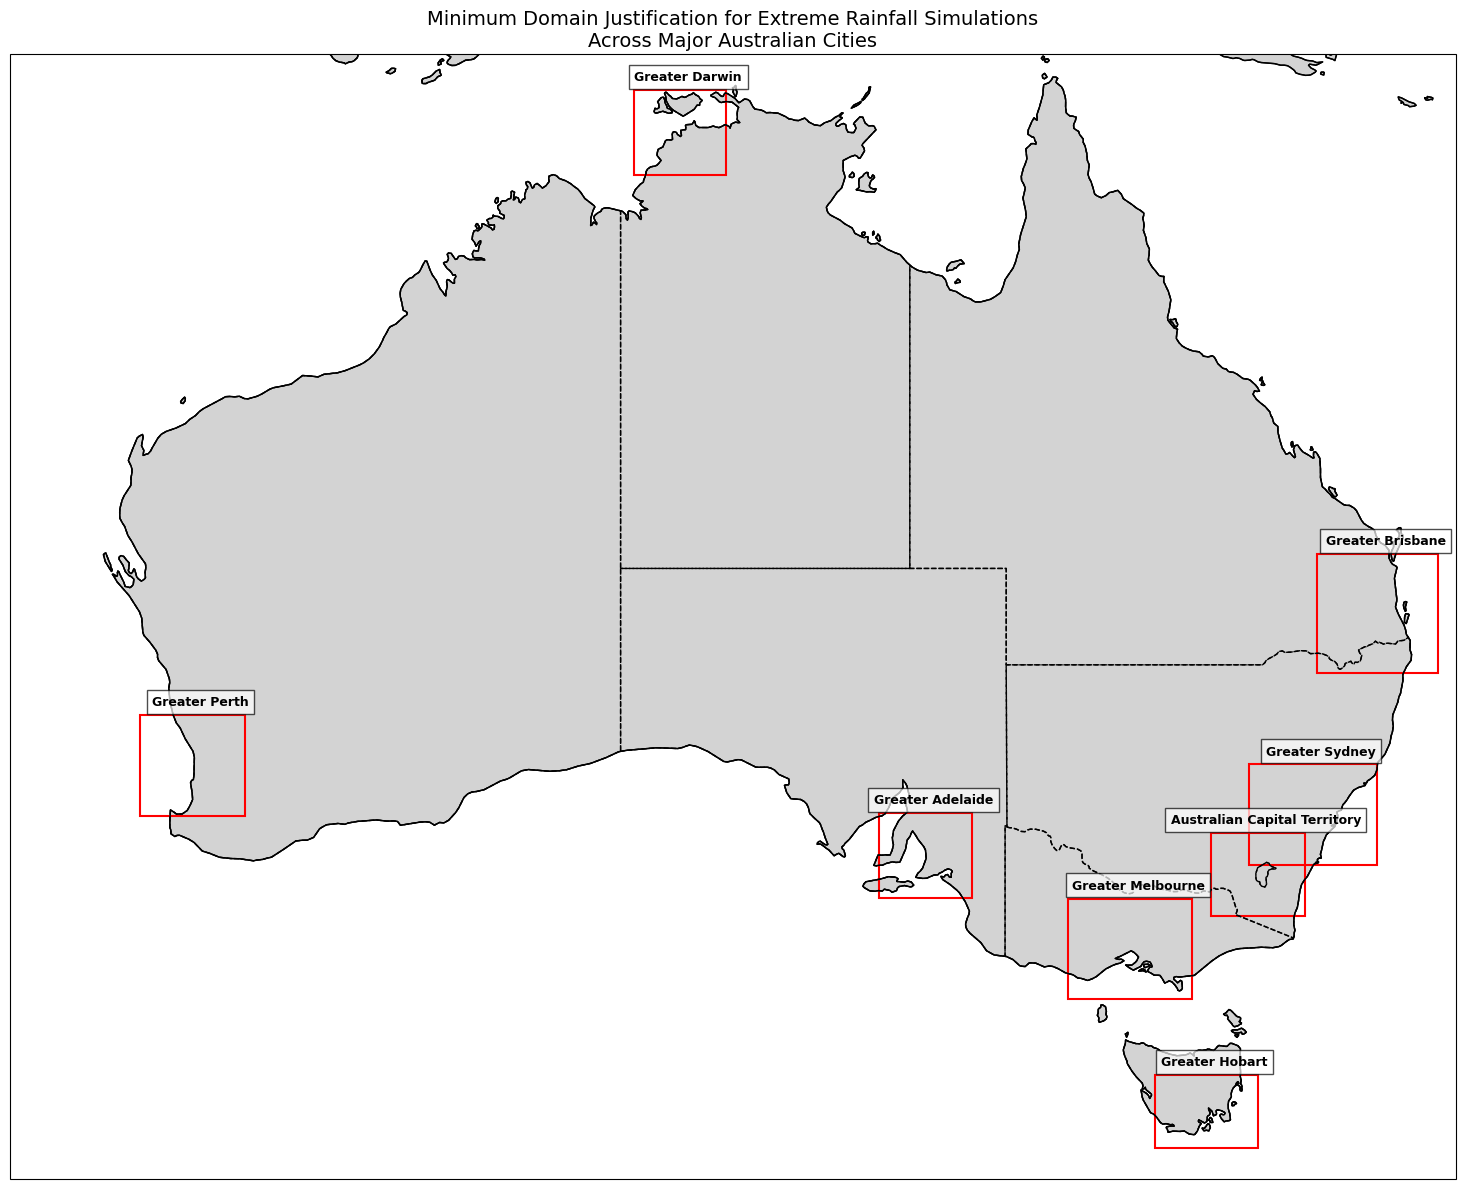

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import os

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Cities to process (official GCCSA names) ===
city_names = [
    "Greater Sydney", "Greater Melbourne", "Greater Brisbane",
    "Greater Perth", "Greater Adelaide", "Greater Hobart",
    "Greater Darwin", "Australian Capital Territory"
]

# === Load GCCSA shapefile ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp).to_crs(epsg=4326)

# === Create national map ===
fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([110, 155, -45, -10], crs=ccrs.PlateCarree())

# Base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# === Buffer and plot domains ===
buffer_deg = 0.9  # ~100 km in degrees
extension_deg = 0.5  # Additional westward padding

for city in city_names:
    region = gccsa[gccsa["GCC_NAME21"].str.contains(city, case=False)]
    if region.empty:
        continue

    minx, miny, maxx, maxy = region.total_bounds
    west = minx - buffer_deg - extension_deg
    east = maxx + buffer_deg
    south = miny - buffer_deg
    north = maxy + buffer_deg

    # Draw red box for minimum domain
    ax.add_patch(Rectangle((west, south), east - west, north - south,
                           edgecolor='red', facecolor='none', lw=1.5,
                           transform=ccrs.PlateCarree()))

    # Annotate city name as-is from GCCSA
    ax.text((minx + maxx) / 2, maxy + 1.2, city,
            ha='center', fontsize=9, weight='bold',
            transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=0.7))

# Final formatting
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nAcross Major Australian Cities", fontsize=14)
plt.tight_layout()
plt.savefig(f"{out_figure_path}/summary_minimum_domains_australia.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [28]:
import geopandas as gpd
import pandas as pd
import os

# === Setup paths ===
# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load GCCSA shapefile ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp).to_crs(epsg=4326)

# === Target cities and short labels ===
city_names = {
    "Greater Sydney": "Sydney",
    "Greater Melbourne": "Melbourne",
    "Greater Brisbane": "Brisbane",
    "Greater Perth": "Perth",
    "Greater Adelaide": "Adelaide",
    "Greater Hobart": "Hobart",
    "Greater Darwin": "Darwin",
    "Australian Capital Territory": "Canberra"
}

# === Settings for domain logic ===
buffer_deg = 0.9  # ~100 km
extension_deg = 0.5  # westward extension

results = []

for official_name, label in city_names.items():
    region = gccsa[gccsa["GCC_NAME21"].str.contains(official_name, case=False)]
    if region.empty:
        continue

    # Region bounding box
    minx, miny, maxx, maxy = region.total_bounds

    # Buffered domain bounds
    west = minx - buffer_deg - extension_deg
    east = maxx + buffer_deg
    south = miny - buffer_deg
    north = maxy + buffer_deg

    # Compute distances from boundary to domain edge
    west_buffer = (minx - west) * 111
    east_buffer = (east - maxx) * 111
    south_buffer = (miny - south) * 111
    north_buffer = (north - maxy) * 111

    results.append({
        "City": label,
        "West Buffer (km)": round(west_buffer, 1),
        "East Buffer (km)": round(east_buffer, 1),
        "South Buffer (km)": round(south_buffer, 1),
        "North Buffer (km)": round(north_buffer, 1)
    })

# === Output table ===
buffer_df = pd.DataFrame(results)
print("\nDirectional Buffer Distance Table (in km):\n")
print(buffer_df.to_string(index=False))

# Optional: save to CSV
buffer_df.to_csv(f"{out_figure_path}/minimum_domain_buffer_distances.csv", index=False)


Directional Buffer Distance Table (in km):

     City  West Buffer (km)  East Buffer (km)  South Buffer (km)  North Buffer (km)
   Sydney             155.4              99.9               99.9               99.9
Melbourne             155.4              99.9               99.9               99.9
 Brisbane             155.4              99.9               99.9               99.9
    Perth             155.4              99.9               99.9               99.9
 Adelaide             155.4              99.9               99.9               99.9
   Hobart             155.4              99.9               99.9               99.9
   Darwin             155.4              99.9               99.9               99.9
 Canberra             155.4              99.9               99.9               99.9


In [29]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load GCCSA shapefile ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp).to_crs(epsg=4326)

# === Direction-specific buffer distances from GCCSA boundary (in km) ===
custom_buffers = {
    "Greater Sydney":    {"label": "Sydney", "W": 180, "E": 80, "S": 100, "N": 100, "extent": [145, 155, -38, -30]},
    "Greater Melbourne": {"label": "Melbourne", "W": 150, "E": 100, "S": 100, "N": 100, "extent": [140, 150, -44, -35]},
    "Greater Brisbane":  {"label": "Brisbane", "W": 150, "E": 100, "S": 100, "N": 100, "extent": [147, 158, -32, -24]},
    "Greater Perth":     {"label": "Perth", "W": 150, "E": 100, "S": 100, "N": 100, "extent": [110, 122, -36, -25]},
    "Greater Adelaide":  {"label": "Adelaide", "W": 120, "E": 100, "S": 120, "N": 100, "extent": [132, 145, -40, -28]},
    "Greater Hobart":    {"label": "Hobart", "W": 100, "E": 100, "S": 150, "N": 100, "extent": [140, 150, -47, -39]},
    "Greater Darwin":    {"label": "Darwin", "W": 100, "E": 100, "S": 100, "N": 180, "extent": [124, 138, -18, -8]},
    "Australian Capital Territory": {"label": "Canberra", "W": 150, "E": 100, "S": 100, "N": 100, "extent": [142, 155, -40, -30]},
}

# === Generate plots ===
for city_name, info in custom_buffers.items():
    region = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]
    if region.empty:
        continue

    minx, miny, maxx, maxy = region.total_bounds
    west = minx - info["W"] / 111
    east = maxx + info["E"] / 111
    south = miny - info["S"] / 111
    north = maxy + info["N"] / 111
    domain_box = box(west, south, east, north)
    domain_gdf = gpd.GeoDataFrame(geometry=[domain_box], crs='EPSG:4326')

    # Plot
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(info["extent"], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=1)
    ax.add_feature(cfeature.STATES, linestyle='--')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

    region.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label=city_name)
    domain_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), label='Minimum Domain')

    ax.set_title(f"Minimum Domain Justification for Extreme Rainfall Simulations\n{info['label']}", fontsize=14)
    ax.legend(loc='lower left')
    plt.tight_layout()
    filename = f"{out_figure_path}/minimum_domain_{info['label'].lower().replace(' ', '_')}_custom.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

In [30]:
# Revised national summary script using updated direction-specific buffer distances

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import os

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load GCCSA shapefile ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp).to_crs(epsg=4326)

# === Direction-specific buffer distances from GCCSA boundary (in km) ===
custom_buffers = {
    "Greater Sydney":    {"label": "Sydney", "W": 180, "E": 80, "S": 100, "N": 100},
    "Greater Melbourne": {"label": "Melbourne", "W": 150, "E": 100, "S": 100, "N": 100},
    "Greater Brisbane":  {"label": "Brisbane", "W": 150, "E": 100, "S": 100, "N": 100},
    "Greater Perth":     {"label": "Perth", "W": 150, "E": 100, "S": 100, "N": 100},
    "Greater Adelaide":  {"label": "Adelaide", "W": 120, "E": 100, "S": 120, "N": 100},
    "Greater Hobart":    {"label": "Hobart", "W": 100, "E": 100, "S": 150, "N": 100},
    "Greater Darwin":    {"label": "Darwin", "W": 100, "E": 100, "S": 100, "N": 180},
    "Australian Capital Territory": {"label": "Australian Capital Territory", "W": 150, "E": 100, "S": 100, "N": 100},
}

# === Create national map ===
fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([110, 155, -45, -10], crs=ccrs.PlateCarree())

# Base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')

# === Plot city boundaries and direction-specific minimum domains ===
for city_name, info in custom_buffers.items():
    region = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]
    if region.empty:
        continue

    minx, miny, maxx, maxy = region.total_bounds
    west = minx - info["W"] / 111
    east = maxx + info["E"] / 111
    south = miny - info["S"] / 111
    north = maxy + info["N"] / 111
    domain_box = box(west, south, east, north)

    # Plot red domain box
    ax.add_geometries([domain_box], crs=ccrs.PlateCarree(),
                      edgecolor='red', facecolor='none', lw=1.5)

    # Add city label
    ax.text((minx + maxx) / 2, maxy + 1.2, info["label"],
            ha='center', fontsize=9, weight='bold',
            transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=0.7))

# Final title and save
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nAcross Major Australian Cities", fontsize=14)
plt.tight_layout()
summary_map_path = f"{out_figure_path}/summary_minimum_domains_australia_custom.png"
plt.savefig(summary_map_path, dpi=300, bbox_inches='tight')
plt.close()

In [9]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import rasterio

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load GCCSA shapefile ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp).to_crs(epsg=4326)

# === Direction-specific buffer distances from GCCSA boundary (in km) ===
custom_buffers = {
    "Greater Sydney":    {"label": "Sydney", "W": 180, "E": 100, "S": 100, "N": 100, "extent": [145, 155, -38, -30]},
    "Greater Melbourne": {"label": "Melbourne", "W": 150, "E": 100, "S": 100, "N": 100, "extent": [140, 150, -44, -35]},
    "Greater Brisbane":  {"label": "Brisbane", "W": 150, "E": 100, "S": 100, "N": 100, "extent": [147, 158, -32, -24]},
    "Greater Perth":     {"label": "Perth", "W": 150, "E": 100, "S": 100, "N": 100, "extent": [110, 122, -36, -25]},
    "Greater Adelaide":  {"label": "Adelaide", "W": 120, "E": 100, "S": 120, "N": 100, "extent": [132, 145, -40, -28]},
    "Greater Hobart":    {"label": "Hobart", "W": 100, "E": 100, "S": 150, "N": 100, "extent": [140, 150, -47, -39]},
    "Greater Darwin":    {"label": "Darwin", "W": 100, "E": 100, "S": 100, "N": 180, "extent": [124, 138, -18, -8]},
    "Australian Capital Territory": {"label": "Canberra", "W": 150, "E": 100, "S": 100, "N": 100, "extent": [142, 155, -40, -30]},
}

# === Generate plots ===
for city_name, info in custom_buffers.items():
    region = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]
    if region.empty:
        continue

    minx, miny, maxx, maxy = region.total_bounds
    west = minx - info["W"] / 111
    east = maxx + info["E"] / 111
    south = miny - info["S"] / 111
    north = maxy + info["N"] / 111
    domain_box = box(west, south, east, north)
    domain_gdf = gpd.GeoDataFrame(geometry=[domain_box], crs='EPSG:4326')

    # Plot
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(info["extent"], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=1)
    ax.add_feature(cfeature.STATES, linestyle='--')
    # ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    
    with rasterio.open(f"{out_figure_path}/raster/SR_HR.tif") as src:
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        image = src.read(1)

    ax.imshow(image, extent=extent, transform=ccrs.PlateCarree(), cmap='gray', alpha=1)
    
    region.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label=city_name)
    domain_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), label='Minimum Domain')

    ax.set_title(f"Minimum Domain Justification for Extreme Rainfall Simulations\n{info['label']}", fontsize=14)
    ax.legend(loc='lower left')
    plt.tight_layout()
    filename = f"{out_figure_path}/minimum_domain_{info['label'].lower().replace(' ', '_')}_topo.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()

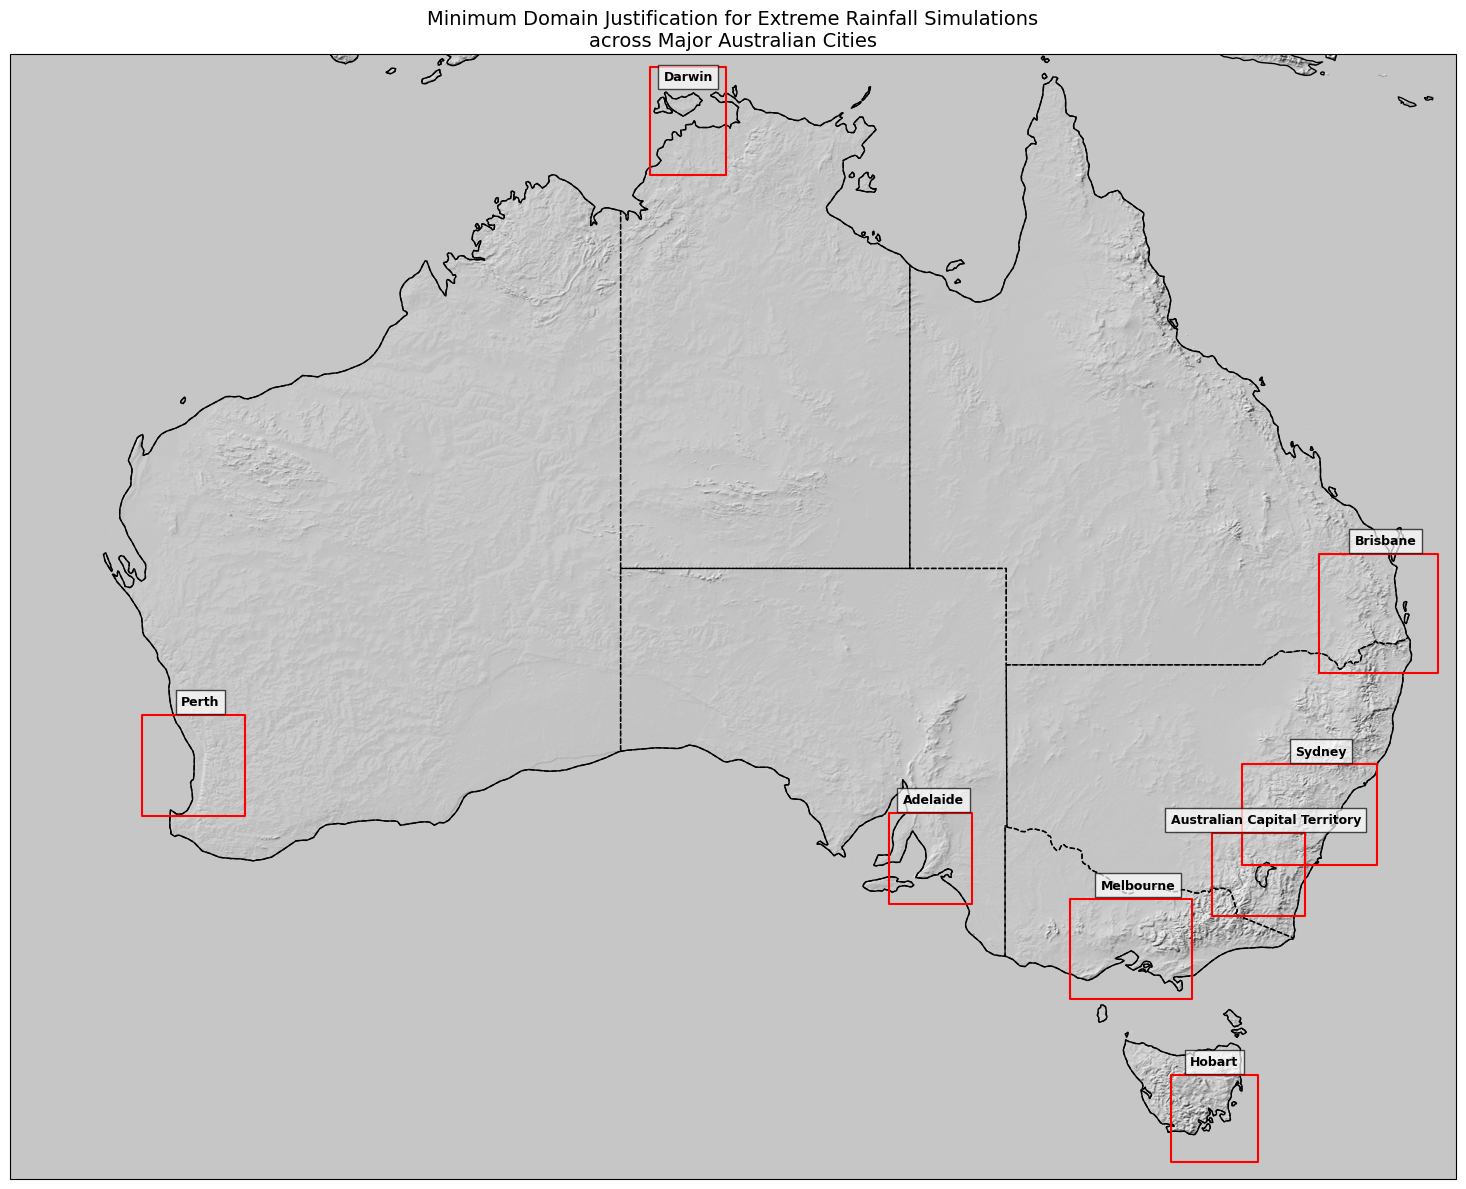

In [12]:
# Revised national summary script using updated direction-specific buffer distances

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import os
import rasterio

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load GCCSA shapefile ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp).to_crs(epsg=4326)

# === Direction-specific buffer distances from GCCSA boundary (in km) ===
custom_buffers = {
    "Greater Sydney":    {"label": "Sydney", "W": 180, "E": 100, "S": 100, "N": 100},
    "Greater Melbourne": {"label": "Melbourne", "W": 150, "E": 100, "S": 100, "N": 100},
    "Greater Brisbane":  {"label": "Brisbane", "W": 150, "E": 100, "S": 100, "N": 100},
    "Greater Perth":     {"label": "Perth", "W": 150, "E": 100, "S": 100, "N": 100},
    "Greater Adelaide":  {"label": "Adelaide", "W": 120, "E": 100, "S": 120, "N": 100},
    "Greater Hobart":    {"label": "Hobart", "W": 100, "E": 100, "S": 150, "N": 100},
    "Greater Darwin":    {"label": "Darwin", "W": 100, "E": 100, "S": 100, "N": 180},
    "Australian Capital Territory": {"label": "Australian Capital Territory", "W": 150, "E": 100, "S": 100, "N": 100},
}

# === Create national map ===
fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([110, 155, -45, -10], crs=ccrs.PlateCarree())

# Base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')
with rasterio.open(f"{out_figure_path}/raster/SR_HR.tif") as src:
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    image = src.read(1)

ax.imshow(image, extent=extent, transform=ccrs.PlateCarree(), cmap='gray', alpha=1)

# === Plot city boundaries and direction-specific minimum domains ===
for city_name, info in custom_buffers.items():
    region = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]
    if region.empty:
        continue

    minx, miny, maxx, maxy = region.total_bounds
    west = minx - info["W"] / 111
    east = maxx + info["E"] / 111
    south = miny - info["S"] / 111
    north = maxy + info["N"] / 111
    domain_box = box(west, south, east, north)

    # Plot red domain box
    ax.add_geometries([domain_box], crs=ccrs.PlateCarree(),
                      edgecolor='red', facecolor='none', lw=1.5)

    # Add city label
    ax.text((minx + maxx) / 2, maxy + 1.2, info["label"],
            ha='center', fontsize=9, weight='bold',
            transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=0.7))

# Final title and save
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nacross Major Australian Cities", fontsize=14)
plt.tight_layout()
summary_map_path = f"{out_figure_path}/summary_minimum_domains_australia_topo.png"
plt.savefig(summary_map_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Revised national summary script using updated direction-specific buffer distances

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import os
import rasterio

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load GCCSA shapefile ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp).to_crs(epsg=4326)

# === Direction-specific buffer distances from GCCSA boundary (in km) ===
custom_buffers = {
    "Greater Sydney":    {"label": "Sydney", "W": 180, "E": 100, "S": 100, "N": 100},
    "Greater Melbourne": {"label": "Melbourne", "W": 150, "E": 100, "S": 100, "N": 100},
    "Greater Brisbane":  {"label": "Brisbane", "W": 150, "E": 100, "S": 100, "N": 100},
    "Greater Perth":     {"label": "Perth", "W": 150, "E": 100, "S": 100, "N": 100},
    "Greater Adelaide":  {"label": "Adelaide", "W": 120, "E": 100, "S": 120, "N": 100},
    "Greater Hobart":    {"label": "Hobart", "W": 100, "E": 100, "S": 150, "N": 100},
    "Greater Darwin":    {"label": "Darwin", "W": 100, "E": 100, "S": 100, "N": 180},
    "Australian Capital Territory": {"label": "Australian Capital Territory", "W": 150, "E": 100, "S": 100, "N": 100},
}

# === Create national map ===
fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([110, 155, -45, -10], crs=ccrs.PlateCarree())

# Base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle='--')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')
tif_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains/srtm-1sec-dem-v1-COG.tif'
with rasterio.open(tif_path) as src:
# with rasterio.open(f"{out_figure_path}/raster/SR_HR.tif") as src:
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    image = src.read(1)

ax.imshow(image, extent=extent, transform=ccrs.PlateCarree(),
          cmap='gist_earth', alpha=0.6)

# === Plot city boundaries and direction-specific minimum domains ===
for city_name, info in custom_buffers.items():
    region = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]
    if region.empty:
        continue

    minx, miny, maxx, maxy = region.total_bounds
    west = minx - info["W"] / 111
    east = maxx + info["E"] / 111
    south = miny - info["S"] / 111
    north = maxy + info["N"] / 111
    domain_box = box(west, south, east, north)

    # Plot red domain box
    ax.add_geometries([domain_box], crs=ccrs.PlateCarree(),
                      edgecolor='red', facecolor='none', lw=1.5)

    # Add city label
    ax.text((minx + maxx) / 2, maxy + 1.2, info["label"],
            ha='center', fontsize=9, weight='bold',
            transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=0.7))

# Final title and save
ax.set_title("Minimum Domain Justification for Extreme Rainfall Simulations\nacross Major Australian Cities", fontsize=14)
plt.tight_layout()
summary_map_path = f"{out_figure_path}/summary_minimum_domains_australia_topo_srtm.png"
plt.savefig(summary_map_path, dpi=300, bbox_inches='tight')
# plt.show()
plt.close()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


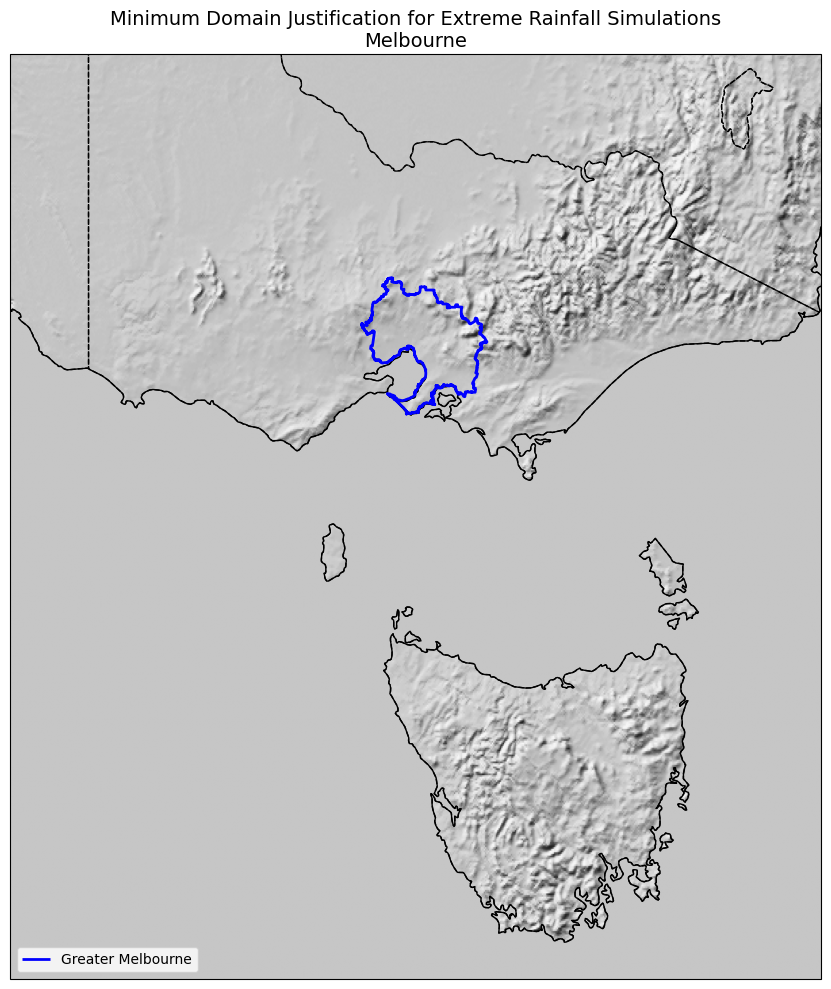

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import rasterio

# === Setup paths ===
file_path = '/g/data/w28/yk8692/nesp/testing_script'
out_figure_path = '/g/data/w28/yk8692/nesp/figure/minimum_domains'
os.makedirs(out_figure_path, exist_ok=True)

# === Load GCCSA shapefile ===
gccsa_shp = f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"
gccsa = gpd.read_file(gccsa_shp).to_crs(epsg=4326)

# === Direction-specific buffer distances from GCCSA boundary (in km) ===
custom_buffers = {
    "Greater Melbourne": {"label": "Melbourne", "W": 150, "E": 100, "S": 100, "N": 100, "extent": [140, 150, -44, -35]},
}

# === Generate plots ===
for city_name, info in custom_buffers.items():
    region = gccsa[gccsa["GCC_NAME21"].str.contains(city_name, case=False)]
    if region.empty:
        continue

    minx, miny, maxx, maxy = region.total_bounds
    west = minx - info["W"] / 111
    east = maxx + info["E"] / 111
    south = miny - info["S"] / 111
    north = maxy + info["N"] / 111
    domain_box = box(west, south, east, north)
    domain_gdf = gpd.GeoDataFrame(geometry=[domain_box], crs='EPSG:4326')

    # Plot
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(info["extent"], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=1)
    ax.add_feature(cfeature.STATES, linestyle='--')
    # ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    
    with rasterio.open(f"{out_figure_path}/raster/SR_HR.tif") as src:
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        image = src.read(1)

    ax.imshow(image, extent=extent, transform=ccrs.PlateCarree(), cmap='gray', alpha=1)
    
    region.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree(), label=city_name)
    # domain_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), label='Minimum Domain')

    ax.set_title(f"Minimum Domain Justification for Extreme Rainfall Simulations\n{info['label']}", fontsize=14)
    ax.legend(loc='lower left')
    plt.tight_layout()
    # filename = f"{out_figure_path}/minimum_domain_{info['label'].lower().replace(' ', '_')}_topo.png"
    # plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()